# Skin cancer image classification

the dataset would be downloaded throught kaggle, to complete this step i had download my kaggle API and upload it to the google colab note book i am using. The next step was to create a folder named kaggle and set the security preference. after doing this step we can download the *ISIC 2018 skin legion dataset* and unzip it. the dataset contains other folders like it's metadata and is 5gb large.

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
!cp kaggle.json ~/.kaggle/

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [01:25<00:00, 125MB/s]
100% 5.20G/5.20G [01:25<00:00, 65.1MB/s]


In [ ]:
!unzip skin-cancer-mnist-ham10000.zip

## Loading in libraries and path

In [42]:
import os
from glob import glob
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot  as plt
from PIL import Image
from pathlib import Path
import imagesize
import numpy as np

base_dir = os.path.join('../content')

In [34]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [35]:
tile_df = pd.read_csv(os.path.join(base_dir, 'HAM10000_metadata.csv'))
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
3458,HAM_0005295,ISIC_0024690,nv,follow_up,40.0,female,back,../content/ham10000_images_part_1/ISIC_0024690...,Melanocytic nevi,4
9485,HAM_0002413,ISIC_0032543,nv,consensus,30.0,male,back,../content/ham10000_images_part_2/ISIC_0032543...,Melanocytic nevi,4
3066,HAM_0005858,ISIC_0028879,nv,follow_up,55.0,male,back,../content/ham10000_images_part_1/ISIC_0028879...,Melanocytic nevi,4


In [37]:
tile_df['cell_type'].unique()

array(['Benign keratosis-like lesions ', 'Melanocytic nevi',
       'Dermatofibroma', 'dermatofibroma', 'Vascular lesions',
       'Basal cell carcinoma', 'Actinic keratoses'], dtype=object)

In [40]:
# load in all of the images
tile_df['image'] = tile_df['path'].map(imread)

In [41]:
# see the image size distribution
tile_df['image'].map(lambda x: x.shape).value_counts()

(450, 600, 3)    10015
Name: image, dtype: int64

In [43]:
tile_df[['cell_type_idx', 'cell_type']].sort_values('cell_type_idx').drop_duplicates()

,cell_type_idx,cell_type
9804,0,Actinic keratoses
2528,1,Basal cell carcinoma
1018,2,Benign keratosis-like lesions
1159,3,Dermatofibroma
7050,4,Melanocytic nevi
2370,5,Vascular lesions
1577,6,dermatofibroma


In [51]:
tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

## converting the size of the image dataset

because the dataset is 450 in height and 600 in width and in RGB format, i would like to downscale the size to help in reducing training time on the GPU

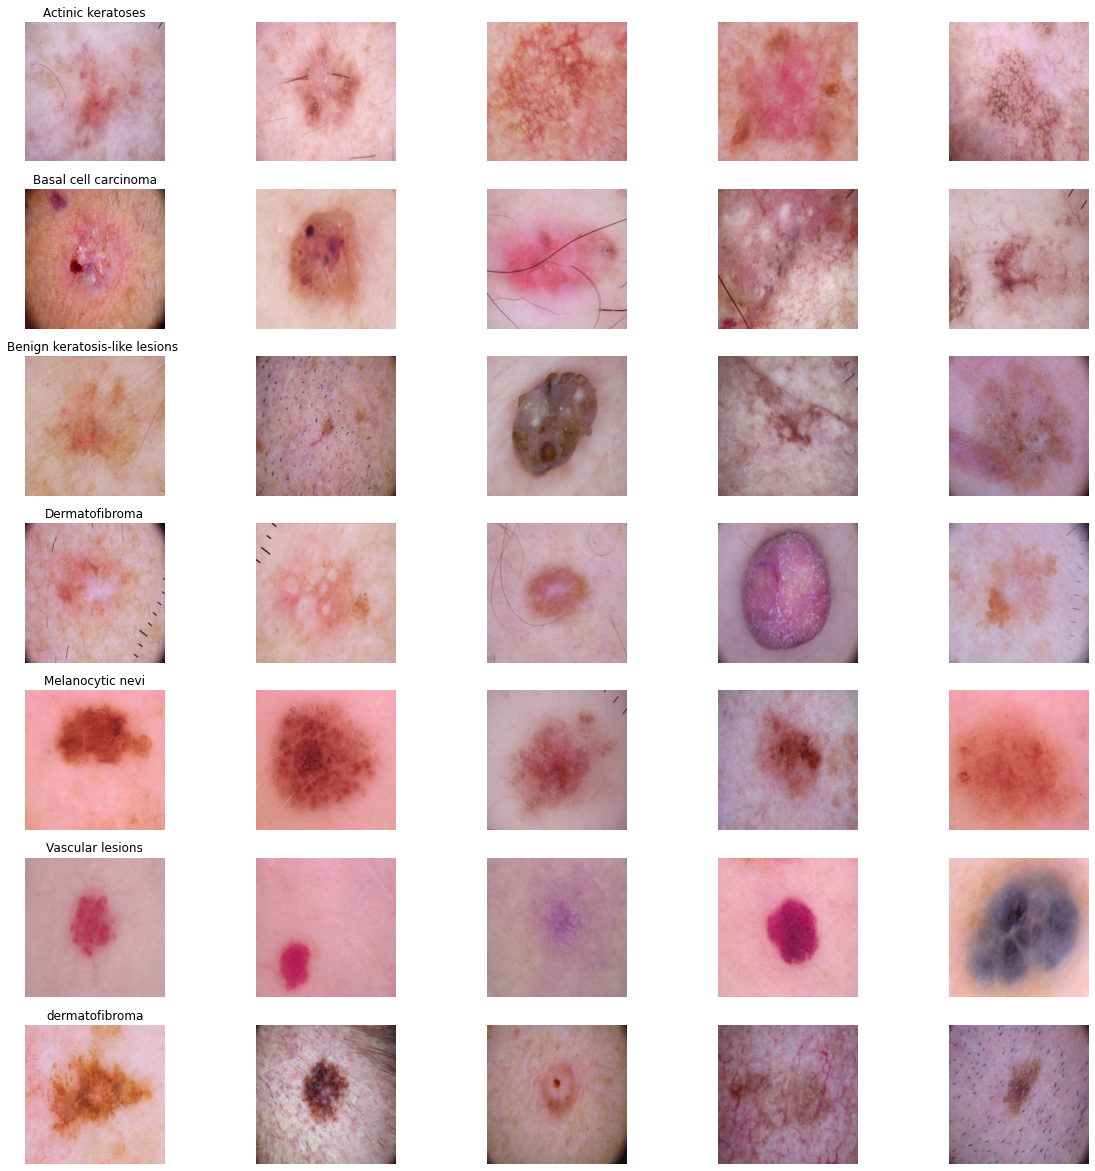

In [52]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [53]:
# See the image size distribution - should just return one row (all images are uniform)
tile_df['image'].map(lambda x: x.shape).value_counts()

(224, 224, 3)    10015
Name: image, dtype: int64